In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

/usr/lib/pymodules/python2.7/matplotlib/__init__.py:907: UserWarning: Duplicate key in file "/etc/matplotlibrc", line #469
  (fname, cnt))


# $U(x_1, x_2, x_3) = \frac{q^2 V^2}{m \Omega_{RF}^2 r_0^4}(x_1^2 + x_2^2 + 4 x_3^2)$

In [2]:
q = 1.6e-19
V = 200
m = 2.89e-25
omegaRF = 2*np.pi*40e6
rnot = 512e-6
A = q**2 * V**2/(m * omegaRF**2 * rnot**4)
wsec = np.sqrt(2*A/m)
print 'Secular freq = ', wsec/2/np.pi

Secular freq =  378274.863649


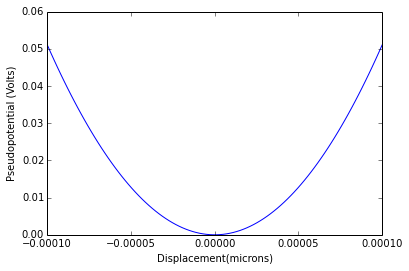

In [3]:
x = np.linspace(-100e-6,100e-6,100)
y = np.linspace(100e-6,-100e-6,100)
xx, yy = np.meshgrid(x,y)
phi = A*(xx**2 + 1 * yy**2)
plt.plot(x, A/q*x**2)
#plt.plot(y, A/q*x**2)
plt.ylabel('Pseudopotential (Volts)')
plt.xlabel('Displacement(microns)')
plt.show()


In [4]:
epsilon = 8.85e-12

def ion_distance(ion1, ion2):
    d = np.sqrt((ion1.x - ion2.x)**2 + (ion1.y - ion2.y)**2)
    return d

def interaction_energy(particle, otherions):
    Eint = 0
    for otherion in otherions:
        x_sep = otherion.x - particle.x
        y_sep = otherion.y - particle.y
        d = np.sqrt(x_sep**2 + y_sep**2)
        Eint += q**2/(4 * np.pi * epsilon * d)
    return 0.5 * Eint

def pos_energy(particle, assy = 1):
    pos_E = A * (assy * particle.x**2 + particle.y**2/assy ) 
    return pos_E

def total_energy(ions, assy):
    E_tot = 0
    for i, particle in enumerate(ions):
        otherions = ions[:i] + ions[i+1 :]
        E_tot += interaction_energy(particle, otherions)
        E_tot += pos_energy(particle, assy)
    return E_tot
    

def plot_ions(ions, colors = None, initial = False):
    x = []
    y = []
    if initial:
        for i, particle in enumerate(ions):
            x.append(particle.x0 * 1e6)
            y.append(particle.y0 * 1e6)        
    else:
        for i, particle in enumerate(ions):
            x.append(particle.x * 1e6)
            y.append(particle.y * 1e6)
    plt.axis('equal')
    #plt.axis([-25e-6, 25e-6, -25e-6, 25e-6])
    if colors:
        plt.scatter(x,y, c = colors) # in microns
    else: 
        plt.scatter(x,y)
    
class ion():
    def __init__(self, x0 = 0, y0= 0, ax0=0,ay0=0, constant = False):
        self.x0= x0
        self.x = self.x0
        self.y0 = y0
        self.y = self.y0
        self.constant = constant

# $$\ddot{\vec{x}}_{ij} = \frac{-2qA}{m}x_{ij} - \frac{q^2}{4 \pi \epsilon_0}\sum_{k\neq j}^{N} \frac{\hat{x}_{ij}\cdot \hat{r}}{|\vec{x}_k-\vec{x}_j|^2}$$

In [26]:
def make_crystal(N_ions = 6, pos_spread = 160e-6, iterations = 800, 
                 step_size = 1e-6, starting_ions = None, assy = 1):
    '''
    This function iterates random steps in postion and recalculates the energy of the configuration of N ions,
    if the energy is decreased it accepts the move and repeats
    '''

    N = N_ions
    ions = []
    if starting_ions == None:
        for i in range(N):
            x0 = (np.random.rand() - 0.5)*pos_spread # initiate ions in random position
            y0 = (np.random.rand() - 0.5)*pos_spread
            ions.append(ion(x0,y0))
    else:
        for i, starting_ion in enumerate(starting_ions): # initiate ions in specified starting positions
            ions.append(ion(starting_ion.x,starting_ion.y))
    E0 = total_energy(ions, assy)
    
    iters = 0
    E = [E0]
    last_E = E0
    ions[0].constant = True
    while iters < iterations:
        iters +=1
        for i, particle in enumerate(ions):
            if particle.constant == False: # Checks if ion is movable
                particle.lastx = particle.x
                particle.x = particle.x + (np.random.rand() - 0.5)*step_size
                particle.lasty = particle.y
                particle.y = particle.y + (np.random.rand() - 0.5)*step_size
                tot_E = total_energy(ions, assy)
                if tot_E < last_E: # Check to take the position step or not
                    E.append(tot_E)
                    last_E = tot_E
                else:
                    particle.x = particle.lastx
                    particle.y = particle.lasty
                    
    return E[-1], ions


In [227]:
print ions[1].x
print ions[1].y

1.31600093414e-07
5.14140959605e-06


In [24]:
#fig, axs = plt.subplots(3,5, figsize=(15, 15), facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = .5, wspace=.001)
#axs = axs.ravel()
prev_ions = None
for i in range(100):
    assymetry = 1 + i*0.0035
    E, ions = make_crystal(N_ions = 6, starting_ions = prev_ions,assy = assymetry, iterations = 2000)
    prev_ions = ions
    x=[]
    y=[]
    for particle in ions:
        x.append(particle.x * 1e6)
        y.append(particle.y * 1e6)
    #plt.axis('equal')
    plt.axis([-23,23,-15,15])
    #axs[i].set_ylim([-15,15])
    #axs[i].set_xlim([-15,15])
    #axs[i].set_ylim([-10,10])
    #plt.xlim([-10,10])
    plt.scatter(x,y)
    plt.text(-20, 13, 'Assymetry = ' + str(assymetry), fontsize=8)
    plt1e6 *.text(-20, 9, 'Step Number = ' + str(i), fontsize=6)
    plt.xlabel('Distance from trap center (um)')
    plt.ylabel('Distance from trap center (um)')
    #axs[i].scatter(x,y)
    #axs[i].text(-3, 1, 'Assymetry = ' + str(assymetry), fontsize=6)
    #axs[i].text(-3, -1, 'Step Number = ' + str(i), fontsize=6)
    plt.savefig('gif_transition/frame_%s.pdf' % str(i))
    plt.clf()
for i in range(101):
    assymetry = (1.35)- i*0.0035
    E, ions = make_crystal(N_ions = 6, starting_ions = prev_ions,assy = assymetry, iterations = 2000)
    prev_ions = ions
    x=[]
    y=[]
    for particle in ions:
        x.append(particle.x * 1e6)
        y.append(particle.y * 1e6)
    plt.axis([-23,23,-15,15])
    #plt.axis('equal')
    #axs[i].set_ylim([-15,15])
    #axs[i].set_xlim([-15,15])
    #axs[7 + i].scatter(x,y)
    #axs[i].set_ylim([-10,10])
    #plt.xlim([-10,10])
    plt.scatter(x,y)
    plt.text(-20, 13, 'Assymetry = ' + str(assymetry), fontsize=8)
    plt.text(-20, 9, 'Step Number = ' + str(100 + i), fontsize=6)
    plt.xlabel('Distance from trap center (um)')
    plt.ylabel('Distance from trap center (um)')
    plt.savefig('gif_transition/frame_%s.pdf' % str(100 + i))
    plt.clf()
#plt.savefig('N=6transition_assymetry.pdf')

0.0
0.0


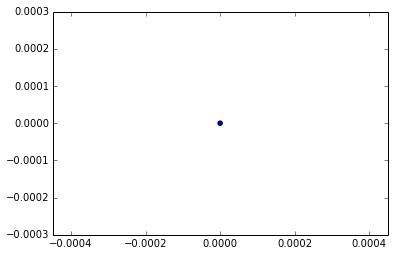

8.16286380734e-27
1e-07


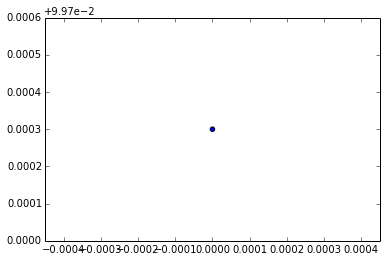

3.26514552294e-26
2e-07


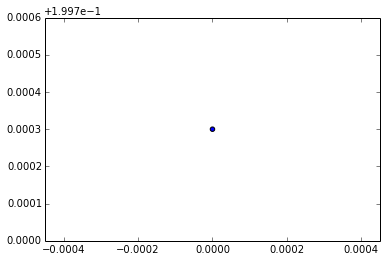

7.34657742661e-26
3e-07


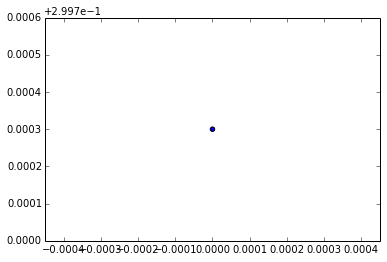

1.30605820917e-25
4e-07


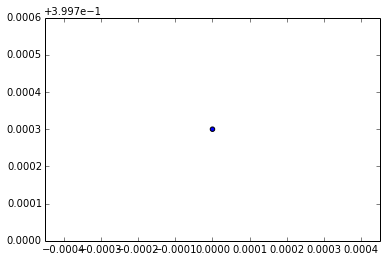

2.04071595184e-25
5e-07


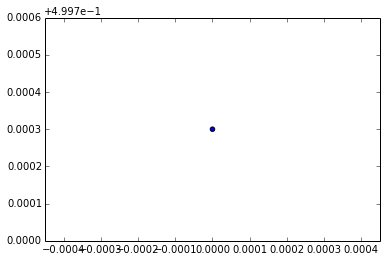

2.93863097064e-25
6e-07


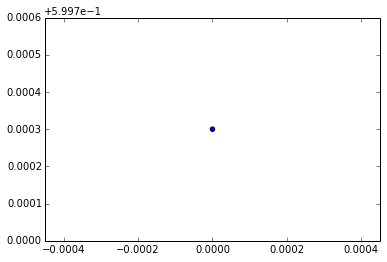

3.9998032656e-25
7e-07


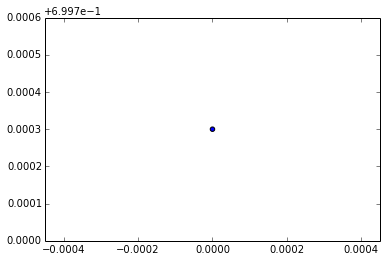

5.2242328367e-25
8e-07


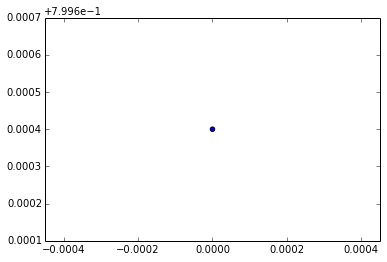

6.61191968395e-25
9e-07


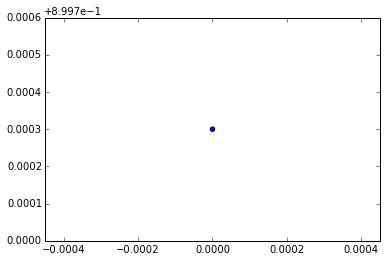

In [27]:
Eprofile = []
Ydistance = []
for i in range(1000):
    starting_ions = one_ion(0)
    starting_ions[0].y = starting_ions[0].y + 1e-9*i
    Ydistance.append(starting_ions[0].y)
    ions[0].constant = True
    E, ions = make_crystal(1, starting_ions = starting_ions, iterations = 2000, pos_spread = 20e-6)
    Eprofile.append(E)
    if i % 100 == 0:
        print E
        print starting_ions[0].y
        plt.show()
        plot_ions(ions)
        plt.savefig('simulated_%s_ion_.pdf' % str(len(ions)))
        plt.show() 

In [198]:
for particle in ions:
    print particle.x

-1.39460847654e-07
1.39153189928e-07
5.44357895282e-06
-5.41623549361e-06
-5.62309756839e-06
5.59195537286e-06


In [199]:
meta_6_ions = ions

In [309]:
plot_ions(make_crystal(6))

AttributeError: 'numpy.float64' object has no attribute 'x'

In [202]:
def symmetric_6(radius):
    ions = []
    ions.append(ion(0,radius))
    ions.append(ion(0,-radius))
    x = radius * np.cos(np.pi/6)
    y = radius * np.sin(np.pi/6)
    ions.append(ion(x,y))
    ions.append(ion(-x,-y))
    ions.append(ion(-x,y))
    ions.append(ion(x,-y))
    return ions

In [203]:
def symmetric_4(radius):
    ions = []
    ions.append(ion(0,radius))
    ions.append(ion(radius,0))
    ions.append(ion(0,-radius))
    ions.append(ion(-radius,0))
    return ions

In [207]:
1e6 *def triangle_4(radius):
    ions = []
    theta = np.pi/6.0
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    ions.append(ion(0,0))
    ions.append(ion(0,radius))
    ions.append(ion(x,-y))
    ions.append(ion(-x,-y))
    return ions

In [234]:
def cross_5(radius):
    ions = []
    ions.append(ion(0,0))
    ions.append(ion(0,radius))
    ions.append(ion(radius,0))
    ions.append(ion(0,-radius))
    ions.append(ion(-radius,0))
    return ions

In [25]:
def one_ion(radius):
    ions = []
    ions.append(ion(0,radius))
    return ions

In [ ]:
Eprofile = np.array(Eprofile)
Ydistance = np.array(Ydistance)

In [ ]:
print np.min(Eprofile)
freq = (Eprofile - np.min(Eprofile))/6.6e-34
print freq

[  1.23679755e+21   1.30471771e-01  -9.78048766e-08]


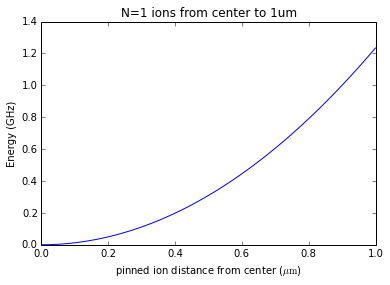

In [55]:
Eprofile = np.array(Eprofile)
Ydistance = np.array(Ydistance)
freq = (Eprofile - np.min(Eprofile))/6.6e-34
plt.plot(Ydistance*1e6 , freq/1e9)
z = np.polyfit(Ydistance , freq, 2)
print z
plt.title('N=1 ions from center to 1um')
#plt.plot(Ydistance * 1e6, z[0]*(Ydistance*1e6)**2, 'g--')
plt.xlabel(r'pinned ion distance from center ($\mu \mathrm{m}$)')
plt.ylabel('Energy (GHz)')
plt.savefig('1_ion_dragged.pdf')

In [66]:
np.savetxt('one_ion_data.csv', np.c_[Ydistance*1e6, freq/1e9], delimiter = ',')

In [ ]:
Eprofile = np.array(Eprofile)
Ydistance = np.array(Ydistance)10
freq = (Eprofile - np.min(Eprofile))/6.6e-34
plt.plot(Ydistance * 1e6, freq/1e9)
plt.title('N=6 ions from ring to 5-1 configuration')
plt.xlabel('pinned ion distance from center (um)')
plt.ylabel('Energy (GHz)')
plt.savefig('6ring-5_1_transition.pdf')

In [ ]:
Eprofile = np.array(Eprofile)
Ydistance = np.array(Ydistance)
freq = (Eprofile - np.min(Eprofile))/6.6e-34
plt.plot(Ydistance * 1e6, freq/1e9)
plt.title('N=6 ions from ring to 5-1 configuration')
plt.xlabel('pinned ion distance from center (um)')
plt.ylabel('Energy (GHz)')
plt.savefig('6ring-5_1_transition.pdf')